In [1]:
cd "~/IBM_Attrition_DataChallenge/"  

/Users/naveenmirapuri/IBM_Attrition_DataChallenge


In [2]:
import pandas as pd
import numpy as np

# to be used for graphing
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# to be used for machine learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

First read in the raw data. Then as a standard practice, return the first few rows to check the dataframe is correct.

In [3]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')         # reads in dataset using pandas
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


We can realize there are four columns that are the same/arbitrary for each person, so we will remove these below.

In [4]:
df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis="columns", inplace=True)

We will check for missing data to ensure that no rows have to be removed/edited. If some values are missing, there are multiple ways to correct the issue. We could use a deletion method (listwise, pairwise, etc.) to remove rows or variables with missing data; however, this is not best practice because it could result in losing lots of information. We could also try to fill in the data using some imputation method. Imputation methods can range from simple mean/median/mode calculations to more complex techniques like the 'nearest neighbors' method, which extracts an estimate only from rows with similar traits.

In [5]:
df.isnull().values.any()

False

There are no null values! This means we don't have to bother with missing data and can move on to the next step.

Next, we will remove any columns with the same value in each row, as they are the same for everyone and will provide no additional information.

We will now check that each employee is only entered in the dataset once. When calculating attrition, it would be fine if an employee was counted twice, say if attrition changes after some promotion/work-life change. However, when gathering general statistics on IBM employees (number of workers, distribution of jobs, etc.), we want to avoid double counting. We will do this through noticing that there is an Employee Number column with unique identifiers.

In [6]:
df["EmployeeNumber"].is_unique

True

Great! Because the column is the same before and after duplicates are removed, there are no employee recurrences to worry about! We can now eliminate EmployeeNumber, as it is an arbitratry variable as well.

In [7]:
df.drop(['EmployeeNumber'], axis="columns", inplace=True)

We also have to eliminate correlated data from the dataframe. Correlated data are variables that have a strong association with eachother and will thus tend to follow related patterns (note: not causation). This is an important step in cleaning the data, as we do not want multiple independent variables conveying the same information to the model. Correlated data can make models unstable and introduce variance/ovrfitting to the dataset by double-counting.

We can only check correlations between numeric values, so we will filter out other types.

In [8]:
#numerics = df.select_dtypes([np.number]); # this is no longer needed as corr already implements a filtering function

We will now use the corr method to return correlation values for all the variables. A correlation close to +/- 1 represents that the variables on each side are highly correlated. As shown, there is a diagonal of 1s where each variable intersects wiith itself and the values in the upper right triangle are perfectly mirrored across the diagonal. The corr function uses Pearson's rank-based measure of association. 

<AxesSubplot:>

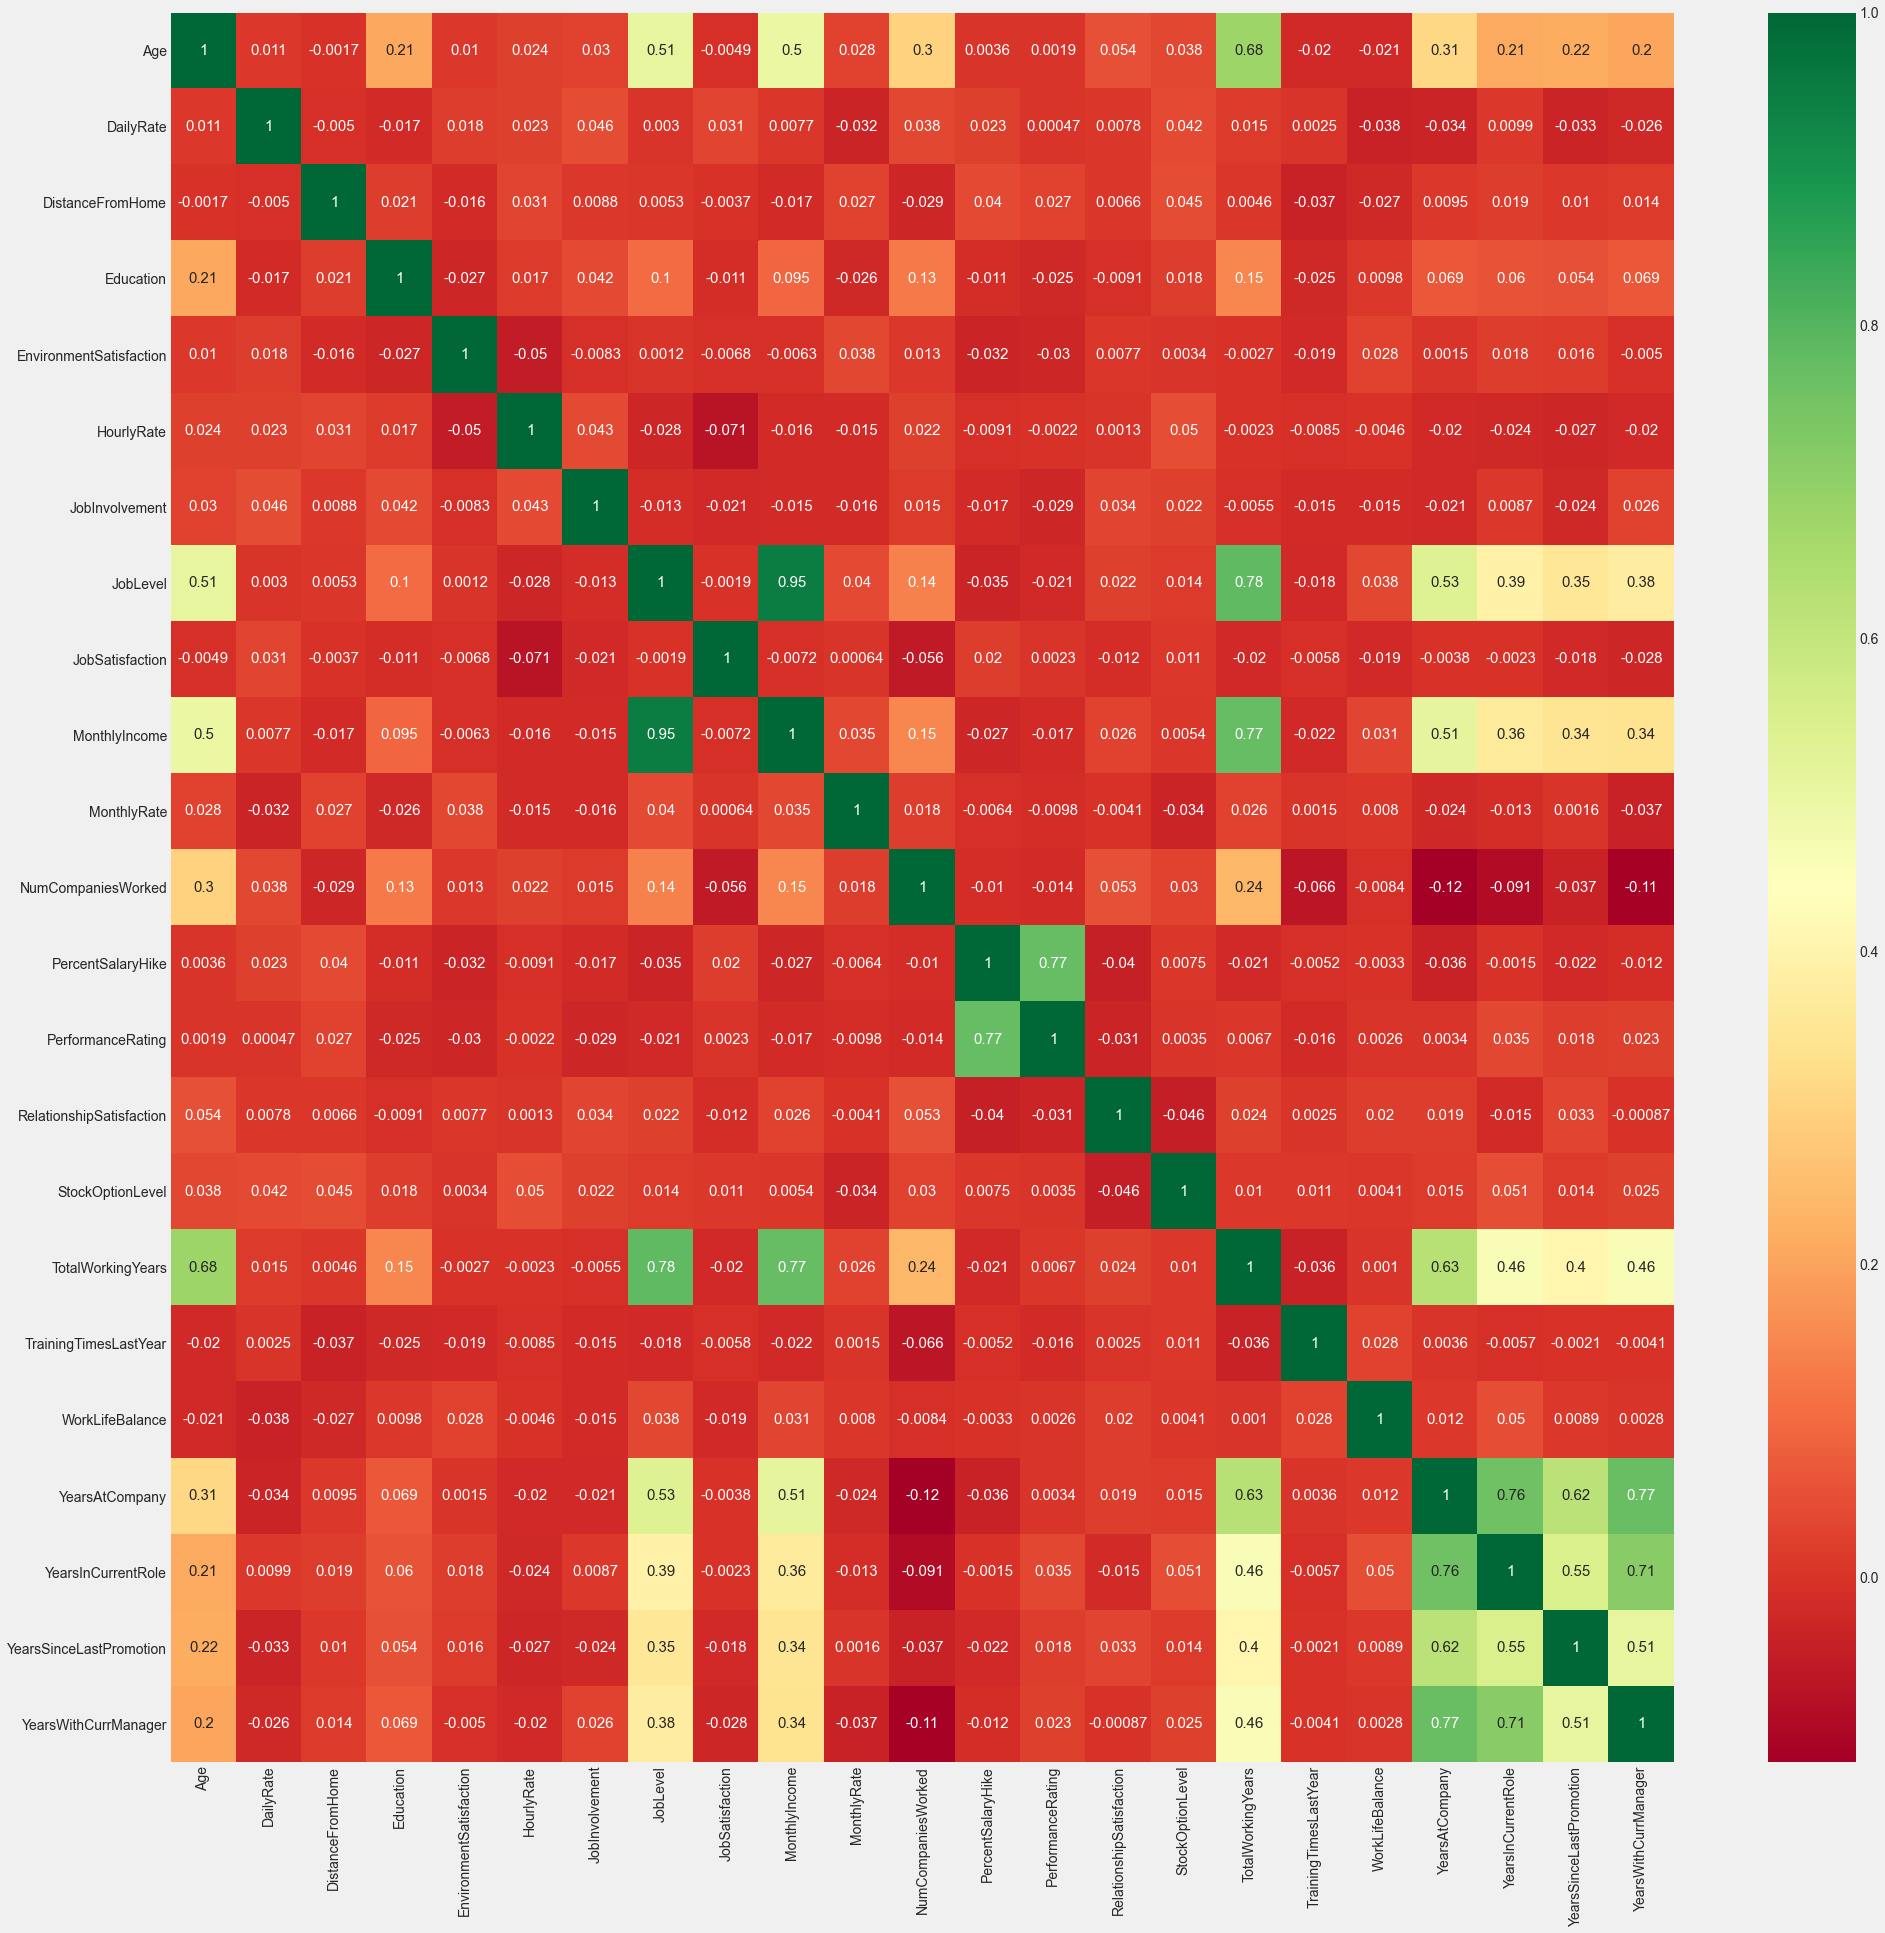

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# This will display the correlation heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", annot_kws={"size":15})

We will use the same method used to generate the matrix again to identify the upper right portion. With the upper right portion, we will be able to check if any correlation values are above a certain threshold and remove them if they are. We only use the upper right because, as mentioned earlier, the matrix is perfeectly reflected across the diagonal. The code below uses a standard 0.77 cutoff value

In [10]:
# calculates correlations and isolates one triangle
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# stores columns that have a threshold higher than 0.77 and should thus be dropped
to_drop = [column for column in upper.columns if any(upper[column] > 0.77)]
print(to_drop)  # displays which columns will be dropped due to high correlation

['MonthlyIncome', 'PerformanceRating', 'TotalWorkingYears']


In [11]:
df = df.drop(df[to_drop], axis=1) # drops the columns found above from the dataframe
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,Yes,11,1,0,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,No,23,4,1,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,Yes,15,2,0,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,Yes,11,3,0,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,No,12,4,1,3,3,2,2,2,2


Before feeding the data into the model, we must first replace all of the categorical variables with dummies. Dummies are created when a categorical column is converted into multiple integer columns of binary values. For example, a column of Gender with category values of Male and Female, would now become two columns in the dataframe, one of 'GenderMale' and 'GenderFemale', each with either a 1 or 0 to indicate whether the row contains that gender. This is done to allow the model to read in and make inferences on categorical data.


We will first have to round up all of the categorical columns, then generate the dummies. We will exclude Attrition when assigning dummies, as we don't want multiple columns of the predictive column.

In [12]:
dfTemp = df.drop(['Attrition'], axis=1)  # drop attrition from the temp datafram to avoid multiple


Common practice here is to loop through the dataframe to identify which columns are categorical and need dummies

In [13]:
categorical = []
for col, value in dfTemp.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

In [14]:
dummies = pd.get_dummies(df[categorical])  # once we have the category names, we can generate the dummies and preview
dummies.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [15]:
# with the dummies created, we will remove the existing categorical columns from the df and append the new dummy 
# versions to the end
df = pd.concat([df.drop(categorical, axis=1),dummies], axis=1)
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,Yes,1102,1,2,2,94,3,2,4,...,0,0,0,1,0,0,0,1,0,1
1,49,No,279,8,1,3,61,2,2,2,...,0,0,1,0,0,0,1,0,1,0
2,37,Yes,1373,2,2,4,92,2,1,3,...,0,0,0,0,0,0,0,1,0,1
3,33,No,1392,3,4,4,56,3,1,3,...,0,0,1,0,0,0,1,0,0,1
4,27,No,591,2,1,1,40,3,1,2,...,0,0,0,0,0,0,1,0,1,0


Lastly in data preparation, we finish with our target. Before trying to build a model, it is important to check the distribution of the data you are trying to solve for. If the data is skewed heavily, then perhaps even a simple 'always yes' or 'always no' model would perform better than any program you could create. Thus, we will map and count the values for each entry of attrition to understand more about the skew.

In [16]:
attr_map = {'Yes':1, 'No':0}
attr_real = df["Attrition"].apply(lambda x: attr_map[x])

In [17]:
df["Attrition"].value_counts()


No     1233
Yes     237
Name: Attrition, dtype: int64

We can see that there are substantially more No values than Yes in terms of attrition. In fact, if you were to create a model which only predicted No, you would be correct over 83% of the time! This is sure to be larger than the models some people create, so it is important to be wary of this number when moving forward. The usual fix for skewed data is to take the logarithm of all values, but seeing as Attrition is a categorical variable, this won't work. Instead, we will have to use a program to create synthetic, realistic minority cases (Yes cases, such that the dataset will be balanced. We will get into which exact libraries to call in a few lines

For now, lets start building the model and get to work instantiating the hyperparameters for the program. We will be using the automated ML framework sklearn to construct our model




In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [19]:
# initiating the basic hyperparameters into the sklearn data structure for holding training/testing data and parameters
train, test, target_train, target_val = train_test_split(df.drop(['Attrition'], axis=1), 
                                                         attr_real, 
                                                         train_size= 0.75,
                                                         random_state=0);

This is the moment python fans across the world have been waiting for.......IIIIIIITTT'S TIMEEEE! 5 rounds for the..

Seriously though, this is where we are going to be fixing the skewness mentioned earlier. We will use a program called SMOTE specialized for classification tasks. As explained, SMOTE creates inference cases to expand the minority portion of the dataset.

In [20]:
from imblearn.over_sampling import SMOTE
regularizer = SMOTE(random_state=0)
train_regularized, target_regularized = regularizer.fit_sample(train,target_train)

In [21]:
seed = 0   # We set our random seed to zero for reproducibility
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
#     'warm_start': True, 
    'max_features': 0.3,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

rf = RandomForestClassifier(**rf_params)

rf.fit(train_regularized, target_regularized)
print("Fitting of Random Forest finished")

Fitting of Random Forest finished


In [22]:
df.drop(['Attrition'], axis =1).head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,19479,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,24907,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,1,3,2396,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,1,3,23159,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,1,2,16632,...,0,0,0,0,0,0,1,0,1,0


In [23]:
rf_predictions = rf.predict(test)
print("Predictions finished")

Predictions finished


In [24]:
print("Accuracy score: {}".format(accuracy_score(target_val, rf_predictions)))
print("="*80)
print(classification_report(target_val, rf_predictions))

Accuracy score: 0.8614130434782609
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       310
           1       0.57      0.50      0.53        58

    accuracy                           0.86       368
   macro avg       0.74      0.71      0.73       368
weighted avg       0.85      0.86      0.86       368



We can now use our random forrest design to identify which features are the most important! According to the graph below, we see that overtime, Job Level, and Stock Option Level are the three most important features. See read.me for more analysis!

In [25]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x = df.drop(['Attrition'], axis=1).columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = df.drop(['Attrition'], axis=1).columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

----END OF CODE-----------

Below is a basic implementation of the automated library h2o, unfortunately, if you wish to explore below, you will
see that the results were not great, so the previous model was preferred

In [26]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_111"; Java(TM) SE Runtime Environment (build 1.8.0_111-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.111-b14, mixed mode)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/q_/x63jnvxs4r72xyfgkgfvlgc80000gn/T/tmpkhksctsf
  JVM stdout: /var/folders/q_/x63jnvxs4r72xyfgkgfvlgc80000gn/T/tmpkhksctsf/h2o_naveenmirapuri_started_from_python.out
  JVM stderr: /var/folders/q_/x63jnvxs4r72xyfgkgfvlgc80000gn/T/tmpkhksctsf/h2o_naveenmirapuri_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_naveenmirapuri_midjmm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [27]:
predictors = list(df.drop(['Attrition'], axis=1))
response = "Attrition"
train = h2o.H2OFrame(train_regularized)
test = h2o.H2OFrame(target_regularized)

train[response] = train[response].asfactor()
test[response] = test[response].asfactor()


#df = h2o.H2OFrame(df)
#df["Attrition"] = df["Attrition"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


H2OTypeError: Argument `python_obj` should be a None | list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse, got Series 0       0
1       0
2       0
3       0
4       0
5       0
6       1
7       0
8       0
9       0
10      1
11      0
12      0
13      0
14      0
15      0
16      0
17      1
18      0
19      0
20      0
21      0
22      0
23      1
24      0
25      0
26      1
27      0
28      0
29      0
       ..
1816    1
1817    1
1818    1
1819    1
1820    1
1821    1
1822    1
1823    1
1824    1
1825    1
1826    1
1827    1
1828    1
1829    1
1830    1
1831    1
1832    1
1833    1
1834    1
1835    1
1836    1
1837    1
1838    1
1839    1
1840    1
1841    1
1842    1
1843    1
1844    1
1845    1
Name: Attrition, Length: 1846, dtype: int64

In [ ]:
train, valid = df.split_frame(ratios=[0.8], seed=1234)

In [ ]:
h2o_Model = H2ORandomForestEstimator(ntrees=30,
                                     max_depth=15,
                                     min_rows=10,
                                     calibrate_model=True,
                                     calibration_frame=valid,
                                     binomial_double_trees=True)

h2o_Model.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame=valid)

perf = h2o_Model.model_performance()
perf